<a href="https://colab.research.google.com/github/daisyKim12/Tensorflow_Study/blob/main/Lecture_C5_sunspot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Category 5

Sequence Data

For this task you will need to train a neural network
to predict sunspot activity using the Sunspots.csv
provided.

Your neural network is expected to have an MAE
of at least 20, with top marks going to one with an MAE
of around 15.

At the bottom is provided some testing
code should you want to check before uploading which measures
the MAE for you.

Strongly recommend you test your model with
this to be able to see how it performs.

Use MAE loss and make it less then 15.

-----------------------------------


#Import

In [ ]:
import csv
import tensorflow as tf
import numpy as np
import urllib

from tensorflow.keras.layers import Dense, LSTM, Lambda, Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber

In [ ]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/Sunspots.csv'
urllib.request.urlretrieve(url, 'sunspots.csv')

('sunspots.csv', <http.client.HTTPMessage at 0x7d05665e3e50>)

#Use CSV file to make a Data Set

In [ ]:
with open('sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  i = 0
  for row in reader:
    print(row)
    i += 1
    if i > 10:
      break

['0', '1749-01-31', '96.7']
['1', '1749-02-28', '104.3']
['2', '1749-03-31', '116.7']
['3', '1749-04-30', '92.8']
['4', '1749-05-31', '141.7']
['5', '1749-06-30', '139.2']
['6', '1749-07-31', '158.0']
['7', '1749-08-31', '110.5']
['8', '1749-09-30', '126.5']
['9', '1749-10-31', '125.8']
['10', '1749-11-30', '264.3']


In [ ]:
sunspots = list()
time_step = list()

with open('sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

In [ ]:
for idx in range(5):
  print(sunspots[idx], end = ' ')

print()

for idx in range(5):
  print(time_step[idx], end = ' ')

96.7 104.3 116.7 92.8 141.7 
0 1 2 3 4 

__Caution__ Make sure the type is not `list`, convert it into `np,array`

In [ ]:
series = np.array(sunspots)
time = np.array(time_step)

In [ ]:
series.shape, time.shape

((3235,), (3235,))

visualization

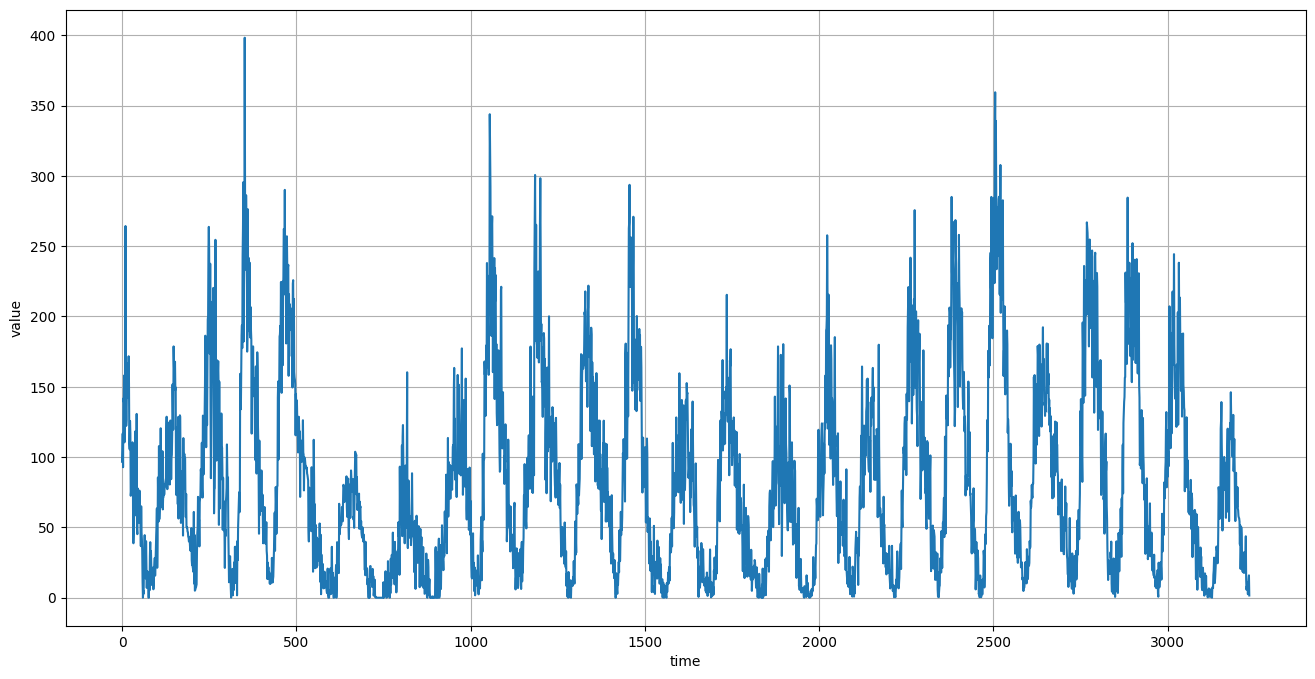

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (16,8))
plt.plot(time, series)
plt.xlabel("time")
plt.ylabel("value")
plt.grid(True)

make train, validation set

In [ ]:
split_time = 3000

time_train = time[:split_time]
time_valid = time[split_time:]

x_train = series[:split_time]
x_valid = series[:split_time]

use window dataset loader

In [ ]:
window_size = 30
batch_size = 32
shuffle_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(x_train,
                             window_size = window_size,
                             batch_size = batch_size,
                             shuffle_buffer = shuffle_size,
                             )
validation_set = windowed_dataset(x_valid,
                                  window_size = window_size,
                                  batch_size = batch_size,
                                  shuffle_buffer=shuffle_size,
                                  )

#Modeling

In [ ]:
model = Sequential([
    Conv1D(60, kernel_size = 5, padding = "causal", activation = 'relu', input_shape = [None, 1]),
    LSTM(60, return_sequences=True),
    LSTM(60, return_sequences=True),
    Dense(30, activation = 'relu'),
    Dense(10, activation = 'relu'),
    Dense(1),
    Lambda(lambda x: x * 400),
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 60)          360       
                                                                 
 lstm (LSTM)                 (None, None, 60)          29040     
                                                                 
 lstm_1 (LSTM)               (None, None, 60)          29040     
                                                                 
 dense (Dense)               (None, None, 30)          1830      
                                                                 
 dense_1 (Dense)             (None, None, 10)          310       
                                                                 
 dense_2 (Dense)             (None, None, 1)           11        
                                                                 
 lambda (Lambda)             (None, None, 1)           0

#Compile, Set Checkpoint, Fit, Load Weight, Evaluate

In **Serial model** using combination of `SGD` and `Huber_loss` is recommended.

In [ ]:
optimizer = SGD(learning_rate = 1e-5, momentum = 0.9)
loss = Huber()

__Caution__: Use MAE to monitor performance.

In [ ]:
model.compile(loss = loss,
              optimizer = optimizer,
              metrics = ['mae'],
              )

In [ ]:
checkpoint_path = 'tmp_checkpoint.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_mae',
                             verbose=1)

In [ ]:
epochs = 20

In [ ]:
history = model.fit(train_set,
                    validation_data = (validation_set),
                    epochs = epochs,
                    callbacks = [checkpoint],
                    )

Epoch 1/20
     93/Unknown - 5s 51ms/step - loss: 19.6430 - mae: 20.1353
Epoch 1: val_mae improved from 21.93341 to 18.96179, saving model to tmp_checkpoint.ckpt
93/93 [==============================] - 10s 109ms/step - loss: 19.6430 - mae: 20.1353 - val_loss: 18.4701 - val_mae: 18.9618
Epoch 2/20
93/93 [==============================] - ETA: 0s - loss: 18.8567 - mae: 19.3490
Epoch 2: val_mae improved from 18.96179 to 18.43311, saving model to tmp_checkpoint.ckpt
93/93 [==============================] - 7s 75ms/step - loss: 18.8567 - mae: 19.3490 - val_loss: 17.9418 - val_mae: 18.4331
Epoch 3/20
93/93 [==============================] - ETA: 0s - loss: 18.1309 - mae: 18.6224
Epoch 3: val_mae improved from 18.43311 to 18.26114, saving model to tmp_checkpoint.ckpt
93/93 [==============================] - 7s 74ms/step - loss: 18.1309 - mae: 18.6224 - val_loss: 17.7704 - val_mae: 18.2611
Epoch 4/20
92/93 [============================>.] - ETA: 0s - loss: 18.6787 - mae: 19.1705
Epoch 4: val_

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
model.evaluate(validation_set)

93/93 [==============================] - 2s 24ms/step - loss: 17.0374 - mae: 17.5277


[17.037376403808594, 17.52774429321289]

In [ ]:
import matplotlib.pyplot as plt

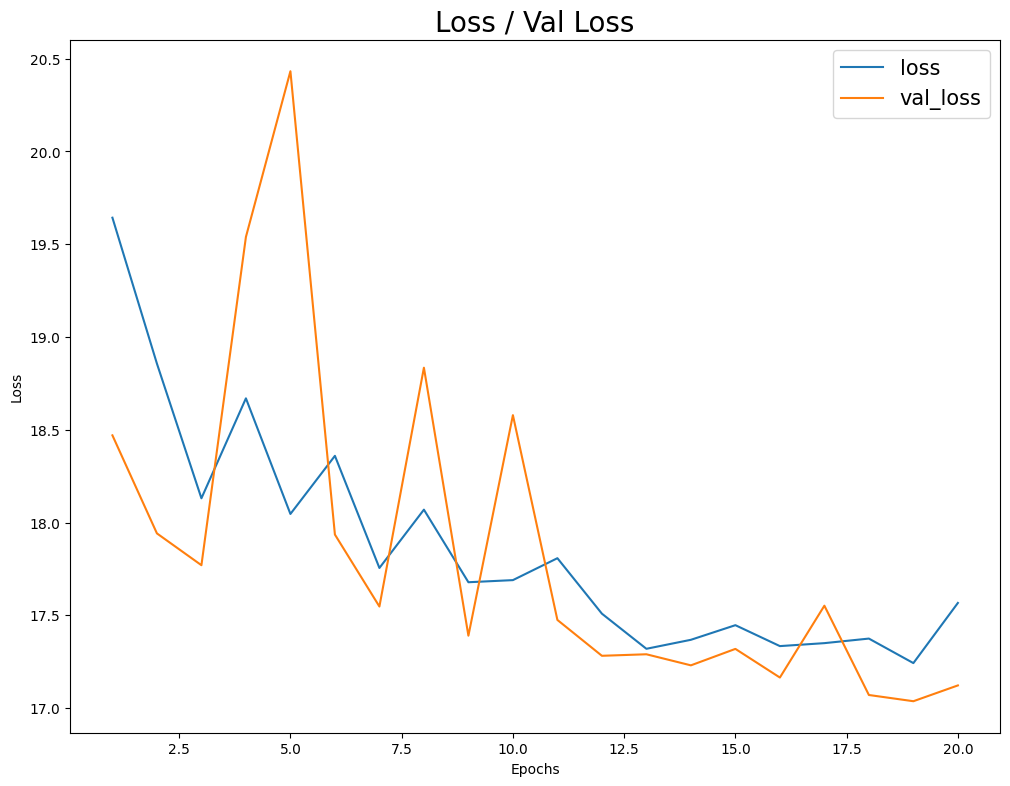

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, epochs+1), history.history['loss'])
plt.plot(np.arange(1, epochs+1), history.history['val_loss'])
plt.title('Loss / Val Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'], fontsize=15)
plt.show()

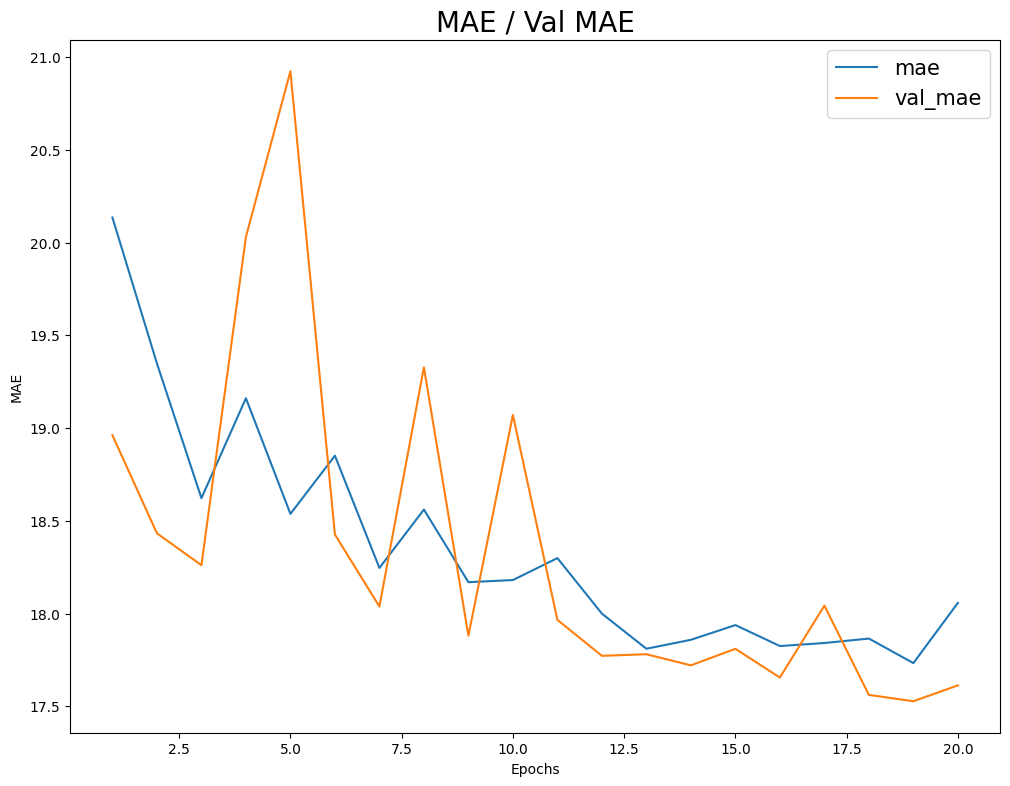

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, epochs+1), history.history['mae'])
plt.plot(np.arange(1, epochs+1), history.history['val_mae'])
plt.title('MAE / Val MAE', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend(['mae', 'val_mae'], fontsize=15)
plt.show()